In [1]:
import os
import pandas as pd
from PIL import Image
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from typing import Tuple

from utils.ml_logging import get_logger

logger = get_logger()

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbb-ai-smart-document-processing"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbb-ai-smart-document-processing


## Building out Ground Truth 📄

We are using the RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing) dataset, which consists of 400,000 grayscale images in 16 classes, with 25,000 images per class. The dataset is split into training, validation, and test sets.

- **Classes**: 16 document types (e.g., letter, form, email).
- **Image Size**: The largest dimension does not exceed 1000 pixels.
- **Splits**:
  - Training: 320,000 images
  - Validation: 40,000 images
  - Test: 40,000 images

The code downloads 100 samples for each class from the RVL-CDIP dataset and saves them in a structured directory. The dataset is used for document image classification tasks, and the images are saved in subdirectories named after their respective classes.

For more information about the RVL-CDIP dataset, please refer to the [dataset page on Hugging Face](https://huggingface.co/datasets/aharley/rvl_cdip). 📚

### Citation 📑

```bibtex
@inproceedings{harley2015icdar,
    title = {Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval},
    author = {Adam W Harley and Alex Ufkes and Konstantinos G Derpanis},
    booktitle = {International Conference on Document Analysis and Recognition ({ICDAR})}},
    year = {2015}
}

In [4]:
import os
from collections import defaultdict
from datasets import load_dataset
from PIL import Image

# Load the dataset in streaming mode
dataset = load_dataset('rvl_cdip', split='test', streaming=True, trust_remote_code=True)

# Initialize a dictionary to store samples for each label
label_samples = defaultdict(list)
num_labels = 16  # Total number of labels
samples_per_label = 100  # Number of samples per label

# Mapping of class labels to their names
_CLASSES = [
    "letter",
    "form",
    "email",
    "handwritten",
    "advertisement",
    "scientific report",
    "scientific publication",
    "specification",
    "file folder",
    "news article",
    "budget",
    "invoice",
    "presentation",
    "questionnaire",
    "resume",
    "memo",
]

# Collect samples_per_label samples per label
for sample in dataset:
    label = sample['label']
    if len(label_samples[label]) < samples_per_label:
        label_samples[label].append(sample)
    
    if all(len(samples) == samples_per_label for samples in label_samples.values()):
        break

## Creating Train and Validation/Test Sets 📊

In this section, we are splitting the dataset into training and testing sets for training and evaluation purposes. The goal is to ensure that our model can learn from a portion of the data (training set) and be evaluated on a separate portion (testing set) to check its performance. Here's what we are doing step-by-step:

1. **Create Directories**: We create directories to store the training and testing images separately.
   - Training images will be stored in `utils\data\scanned\train`.
   - Testing images will be stored in `utils\data\scanned\test`.
2. **Split the Data**: For each class, we split the images into 70% for training and 30% for testing.
3. **Save Images**: We save the images in their respective directories.
4. **Write to CSV**: We write the image paths and labels to a CSV file for easy reference and future use. The CSV file will be located at `utils\data\scanned\image_data.csv`.

In [7]:
import csv
import random
from collections import defaultdict
import os
from datasets import load_dataset
from PIL import Image

main_dir = r'utils\data\scanned'
os.makedirs(main_dir, exist_ok=True)

train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Prepare to write to CSV
csv_path = os.path.join(main_dir, 'image_data.csv')
csv_columns = ['location', 'label', 'set']
csv_file = open(csv_path, 'w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
csv_writer.writeheader()

for label, samples in label_samples.items():
    class_name = _CLASSES[label]
    class_train_dir = os.path.join(train_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)
    
    random.shuffle(samples)
    split_index = int(len(samples) * 0.7)
    train_samples = samples[:split_index]
    test_samples = samples[split_index:]
    
    for i, sample in enumerate(train_samples):
        image = sample['image']
        image_path = os.path.join(class_train_dir, f"{class_name}_{i}.png")
        image.save(image_path)
        csv_writer.writerow({'location': image_path, 'label': class_name, 'set': 'train'})
    
    for i, sample in enumerate(test_samples):
        image = sample['image']
        image_path = os.path.join(class_test_dir, f"{class_name}_{i}.png")
        image.save(image_path)
        csv_writer.writerow({'location': image_path, 'label': class_name, 'set': 'test'})

csv_file.close()

print("Images have been saved successfully and CSV file created.")

Images have been saved successfully and CSV file created.


## Analyzing Training and Test Data 📊

In [13]:
import pandas as pd

# Path to the CSV file
csv_path = r'utils\data\scanned\image_data.csv'

df = pd.read_csv(csv_path)
df.head()


,location,label,set
0,utils\data\scanned\train\scientific report\sci...,scientific report,train
1,utils\data\scanned\train\scientific report\sci...,scientific report,train
2,utils\data\scanned\train\scientific report\sci...,scientific report,train
3,utils\data\scanned\train\scientific report\sci...,scientific report,train
4,utils\data\scanned\train\scientific report\sci...,scientific report,train


Number of images per class in training and testing sets:


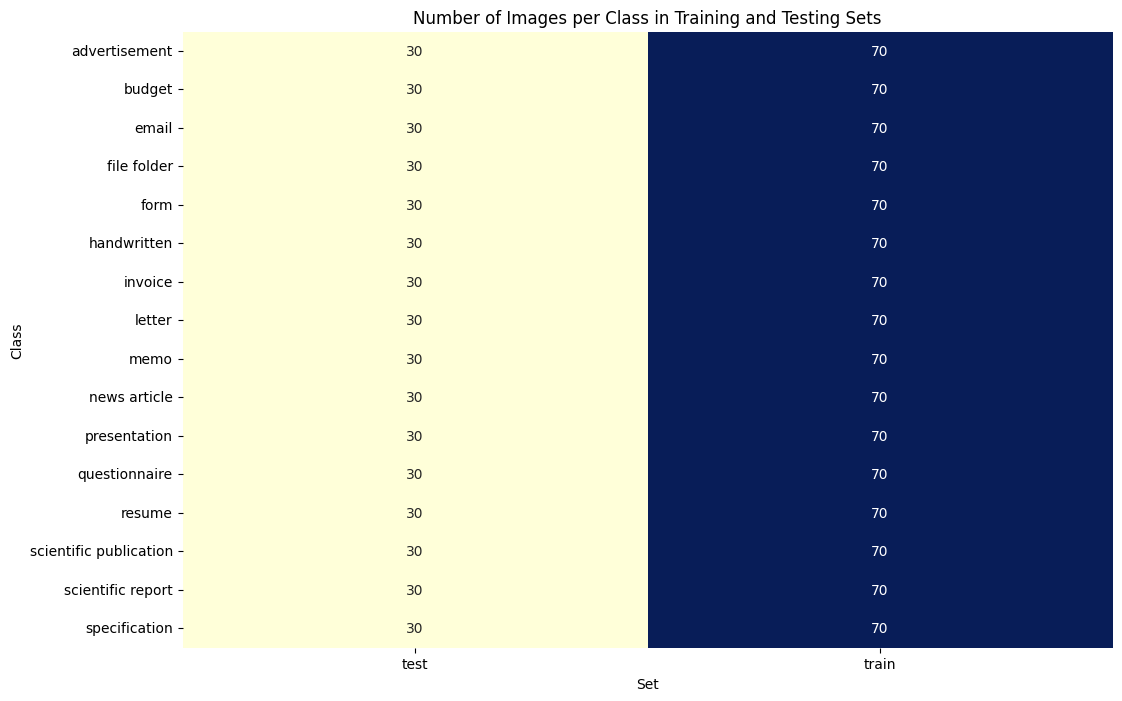

In [17]:
# Group by label and set to get the number of images per class in both training and testing sets
grouped_counts = df.groupby(['label', 'set']).size().unstack(fill_value=0)

print("Number of images per class in training and testing sets:")
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_counts, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Number of Images per Class in Training and Testing Sets")
plt.xlabel("Set")
plt.ylabel("Class")
plt.show()